# Gradient Boosting

This notebook is Gradient Boosting practice and implementation of Gradient Boosting model classes from scratch with previously implemented base model DecisionTreeRegression.

Link to DecisionTree practice notebook - https://github.com/Maxstef/data-loves-ml-for-people-course/blob/main/notebooks/2_3_decision_tree/0_2_decision_tree_from_scratch.ipynb

## Regression Example

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from mlpeople.models.ensemble.gradient_boosting import (
    SimpleGradientBoostingRegressor
)
from mlpeople.models.tree.regression import DecisionTreeRegression

### Generate Nonlinear Data

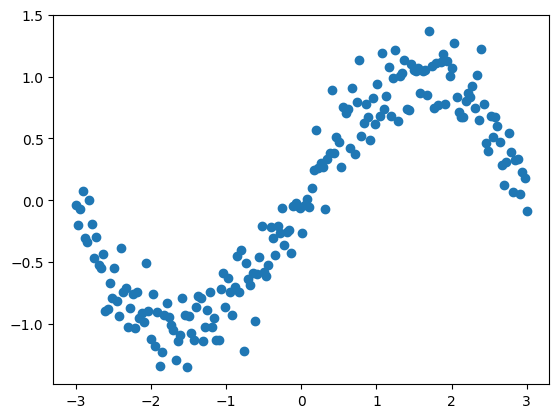

In [2]:
import matplotlib.pylab as plt

# Synthetic nonlinear regression data
np.random.seed(42)

X = np.linspace(-3, 3, 200).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.2, size=200)
plt.scatter(X, y);

### Train Single Tree (Baseline)

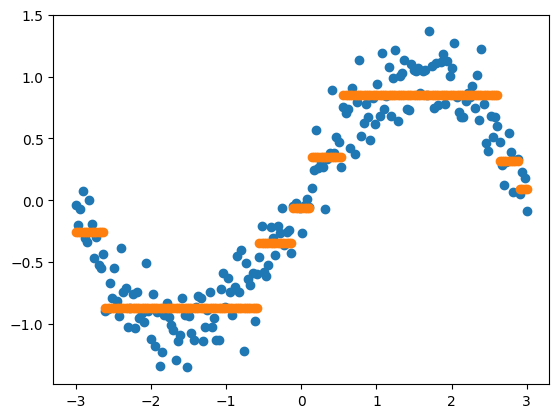

In [3]:
tree = DecisionTreeRegression(max_depth=3)
tree.fit(X, y)

y_tree = tree.predict(X)

plt.scatter(X, y)
plt.scatter(X, y_tree);

### Train Gradient Boosting

In [4]:
gbr = SimpleGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2
)

gbr.fit(X, y)

y_boost = gbr.predict(X)

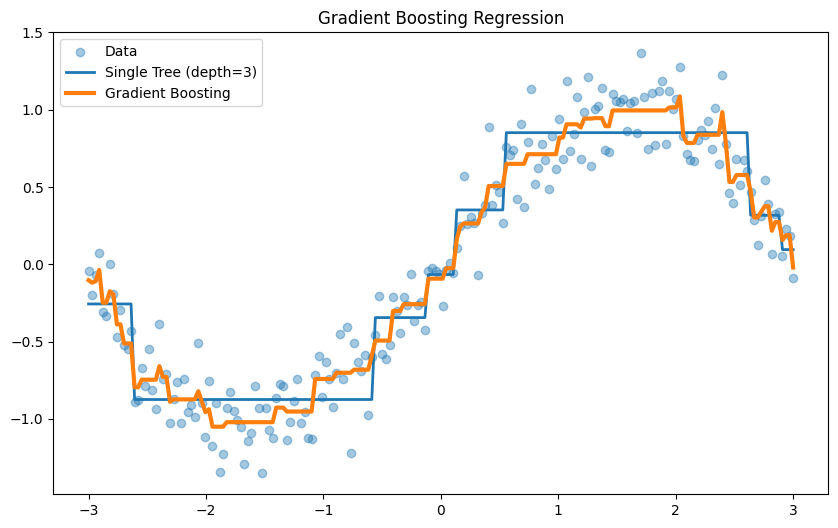

In [5]:
plt.figure(figsize=(10,6))

plt.scatter(X, y, alpha=0.4, label="Data")
plt.plot(X, y_tree, label="Single Tree (depth=3)", linewidth=2)
plt.plot(X, y_boost, label="Gradient Boosting", linewidth=3)

plt.legend()
plt.title("Gradient Boosting Regression")
plt.show()

### MSE vs. MAE loss

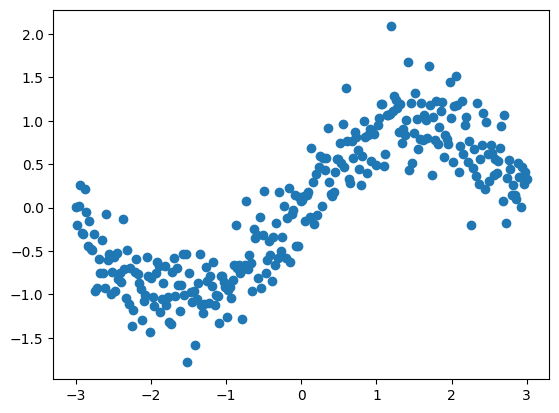

In [6]:
np.random.seed(42)

X = np.linspace(-3, 3, 300).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, size=X.shape[0])
plt.scatter(X, y);

In [7]:
from mlpeople.models.ensemble.gradient_boosting import GeneralGradientBoosting
from mlpeople.models.ensemble.gradient_boosting import SquaredLoss, Loss

class MAELoss(Loss):

    def loss(self, y, F):
        return np.abs(y - F)

    def gradient(self, y, F):
        return np.sign(F - y)

mse_model = GeneralGradientBoosting(
    loss=SquaredLoss(),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=2
)

mae_model = GeneralGradientBoosting(
    loss=MAELoss(),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=2
)

mse_model.fit(X, y)
mae_model.fit(X, y)


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_preds = mse_model.predict(X)
mae_preds = mae_model.predict(X)

print("=== SquaredLoss model ===")
print("RMSE:", np.sqrt(mean_squared_error(y, mse_preds)))
print("MAE :", mean_absolute_error(y, mse_preds))

print("\n=== MAELoss model ===")
print("RMSE:", np.sqrt(mean_squared_error(y, mae_preds)))
print("MAE :", mean_absolute_error(y, mae_preds))

=== SquaredLoss model ===
RMSE: 0.19506220084358236
MAE : 0.15347841403316825

=== MAELoss model ===
RMSE: 0.24070737707735068
MAE : 0.16730021267353498


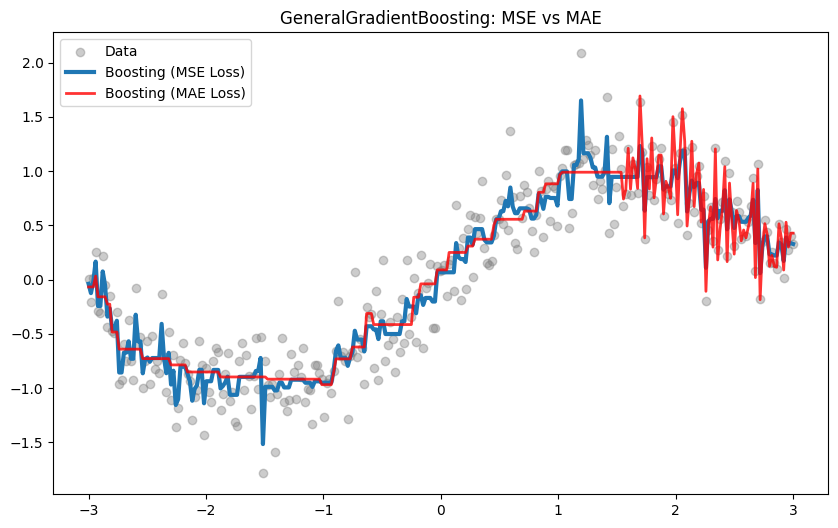

In [9]:
plt.figure(figsize=(10,6))

plt.scatter(X, y, alpha=0.4, label="Data", c="grey")

plt.plot(X, mse_preds, label="Boosting (MSE Loss)", linewidth=3, alpha=1)
plt.plot(X, mae_preds, label="Boosting (MAE Loss)", linewidth=2, alpha=0.8, c="red")

plt.legend()
plt.title("GeneralGradientBoosting: MSE vs MAE")
plt.show()

## Binary Classification Example

### Imports

In [10]:
from mlpeople.models.ensemble.gradient_boosting import BinaryGradientBoosting
from mlpeople.models.logistic.data import generate_binary_classification_sklearn

### Generate Data

In [11]:
X, y = generate_binary_classification_sklearn(
    n_samples=500,
    flip_y=0.2,
    random_state=42
)

In [12]:
np.unique(y)

array([0, 1])

In [13]:
y = np.where(y == 0, -1, 1)

### Train Boosting Classifier & Predict

In [14]:
gbc = BinaryGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2
)

gbc.fit(X, y)

In [15]:
y_pred = gbc.predict(X)

In [16]:
accuracy = np.mean(y_pred == y)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.856


In [17]:
gbc.predict_proba(X)[:, 1][:10]

array([0.81625896, 0.32093184, 0.57243176, 0.81625896, 0.1566533 ,
       0.81256914, 0.81625896, 0.1566533 , 0.81625896, 0.81625896])

### Visualize Loss History and Decision Boundary

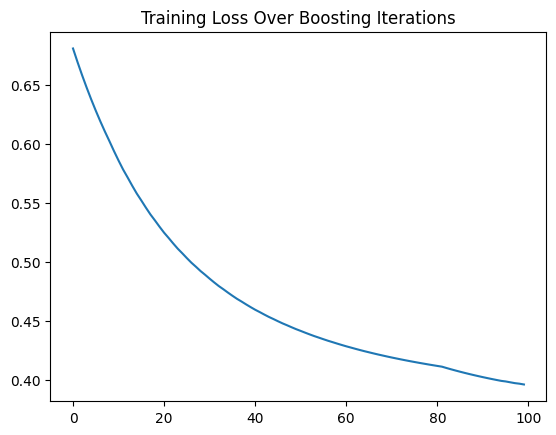

In [18]:
plt.plot(gbc.loss_history)
plt.title("Training Loss Over Boosting Iterations")
plt.show()

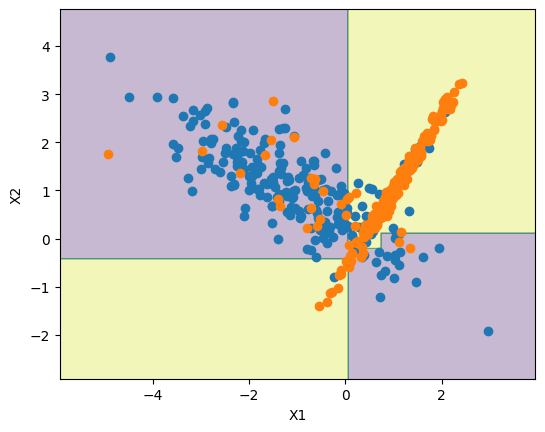

In [19]:
from mlpeople.visualization.classification.single_label import plot_decision_regions

plot_decision_regions(gbc, X, y)

### Visualizing Learning Rate Effect

In [20]:
X, y = generate_binary_classification_sklearn(
    n_samples=500,
    class_sep=1.5,
    random_state=42
)

y = np.where(y == 0, -1, 1)

In [21]:
learning_rates = [1.0, 0.1, 0.01]
models = []

for lr in learning_rates:
    model = BinaryGradientBoosting(
        n_estimators=300,
        learning_rate=lr,
        max_depth=2
    )
    model.fit(X, y)
    models.append(model)

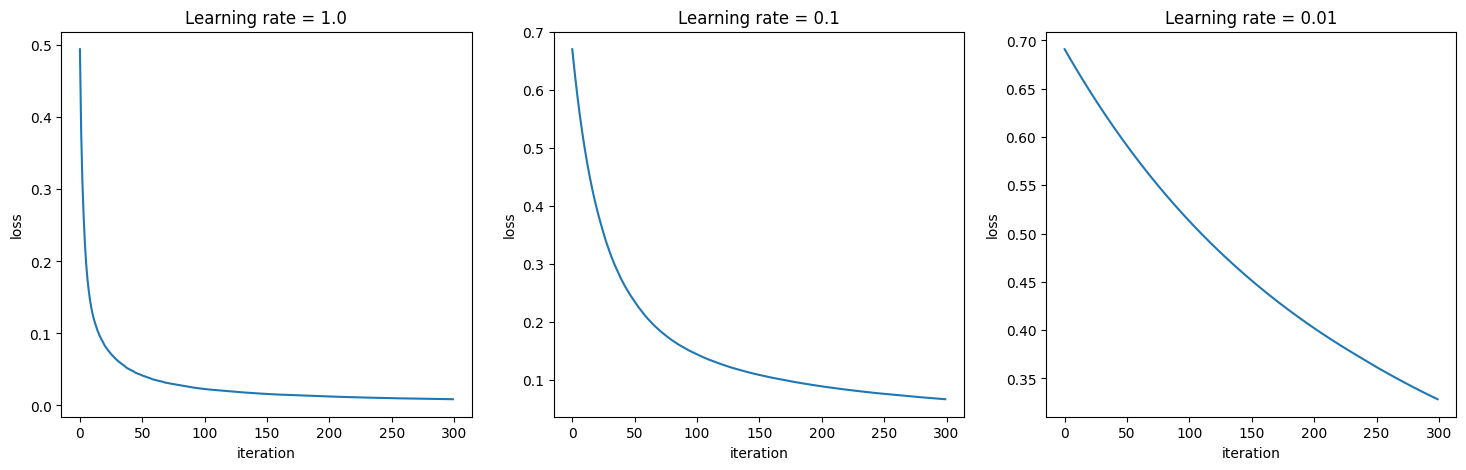

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, model, lr in zip(axes, models, learning_rates):
    ax.plot(model.loss_history)
    ax.set_xlabel("iteration")
    ax.set_ylabel("loss")
    ax.set_title(f"Learning rate = {lr}")

plt.show()

### Compare to sklearn

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss

sk_model = GradientBoostingClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=2,
    random_state=42
)

sk_model.fit(X, y)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",50
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",2
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, `

In [24]:
my_preds = models[1].predict(X)      # lr=0.1 model
sk_preds = sk_model.predict(X)

print("Custom model accuracy:", accuracy_score(y, my_preds))
print("Sklearn accuracy:", accuracy_score(y, sk_preds))

Custom model accuracy: 0.99
Sklearn accuracy: 0.988


In [25]:
my_proba = models[1].predict_proba(X)
sk_proba = sk_model.predict_proba(X)[:, 1]

print("Custom log loss:", log_loss(y, my_proba))
print("Sklearn log loss:", log_loss(y, sk_proba))

Custom log loss: 0.06663254034911904
Sklearn log loss: 0.04479126537904701


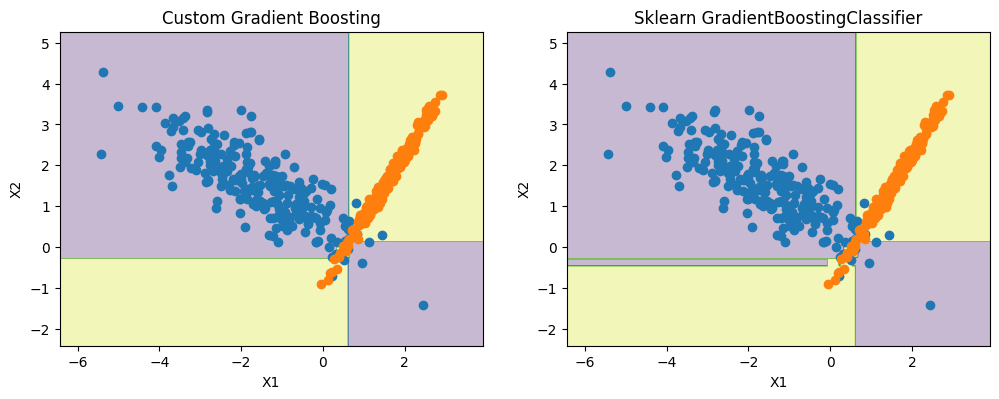

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_decision_regions(models[1], X, y, ax=axes[0])
axes[0].set_title("Custom Gradient Boosting")

plot_decision_regions(sk_model, X, y, ax=axes[1])
axes[1].set_title("Sklearn GradientBoostingClassifier")

plt.show()